In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import neighbors, metrics, preprocessing
pd.options.mode.chained_assignment = None

In [2]:
# Spotify features
# https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

#leemos el dataset
dataset_spotify = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
dataset_spotify.head()
dataset_spotify.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [3]:
dataset_spotify.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


### Imprimo la distribucion de las features

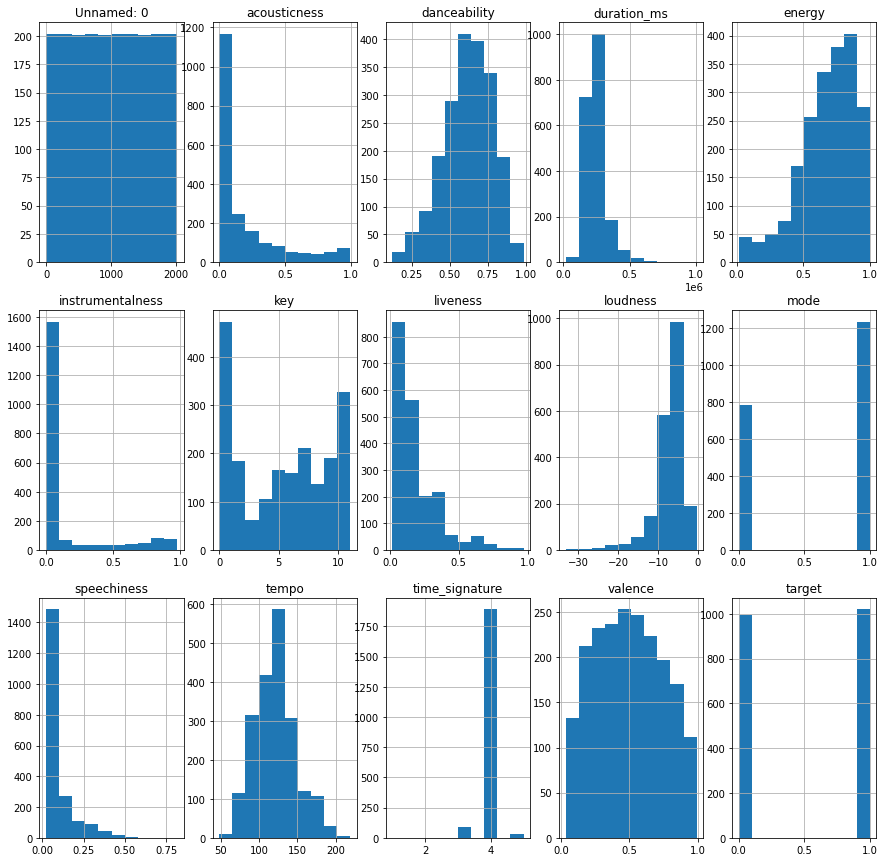

In [4]:
idx = 1

plt.subplots(3,5,figsize=(15,15))

for key, data in dataset_spotify.iteritems():
       
    if( key != 'artist' and key != 'song_title'):
        plt.subplot(3, 5, idx)
        data.hist()
        plt.title(key)
        idx = idx + 1
plt.show()

## Analisis preliminar

Para crear el clasificador vamos a extraer las features mas relevantes. En primera instancia se extrajeron las features mas relevantes desde una perspectiva musical.

A continuacion se hace un analisis de algunas features que ameritan un comentario-


key : La tonalidad de la cancion, es un poco relativo este atributo ya que existen diversos modos dentro de una misma tonalidad, incluso la tonalidad puede cambiar entre una estrofa y un estribillo. A mi criterio no es una feature relevante para el analisis, al menos en la forma en la que spotify etiqueta este campo no me termina de convencer.

liveness: Esto no deberia influir, aunque hay personas que prefieren  versiones en vivo de las canciones antes que una grabacion de estudio. Se podria incluir en una segunda iteracion para evaluar resultados.

loudness: Es una metrica de volumen de la pista.

Speechiness: esto se podria descartar ya que deberia estar fuertemente correlacionado con instrumentalness, se podria hacer un analisis entre esas dos columnas.

Time signature: Eventualmente podria llegar a influir pero considero que hay parametros mas relevantes.

Unnamed: 0: Es el numero de fila del dataset, no aporta nada al clasificador.

Tempo: Este parametro suele estar relacionado a danceability

mode: Es la escala en la cual se encuentra la cancion. Puede ser mayor o menor, las escalas menores son musicalmente mas "tristes" y las mayores suenan mas "alegre". Esto impacta en como se percibe la musica desde una perspectiva psicoacustica. 




### Seleccion de features

In [5]:

## evaluo informacion mutua entre feactures y labels para definir la seleccion

for key in dataset_spotify:
    MI = metrics.mutual_info_score( dataset_spotify[key], dataset_spotify['target'])
    print("%s \t \t|"% key, "MI: %f" % MI)

Unnamed: 0 	 	| MI: 0.693082
acousticness 	 	| MI: 0.478568
danceability 	 	| MI: 0.227508
duration_ms 	 	| MI: 0.671391
energy 	 	| MI: 0.228983
instrumentalness 	 	| MI: 0.403923
key 	 	| MI: 0.005212
liveness 	 	| MI: 0.250915
loudness 	 	| MI: 0.628203
mode 	 	| MI: 0.002620
speechiness 	 	| MI: 0.258406
tempo 	 	| MI: 0.660428
time_signature 	 	| MI: 0.001903
valence 	 	| MI: 0.297482
target 	 	| MI: 0.693082
song_title 	 	| MI: 0.684147
artist 	 	| MI: 0.661691


In [6]:
## basandome en la metrica de informacion mutua entre feature y target junto con el analisis preliminar de los datos elijo las features para armar el modelo:

features = dataset_spotify[['acousticness',	'loudness',	'tempo', 'energy']]
features.head()


,acousticness,loudness,tempo,energy
0,0.0102,-8.795,150.062,0.434
1,0.1990,-10.401,160.083,0.359
2,0.0344,-7.148,75.044,0.412
3,0.6040,-15.236,86.468,0.338
4,0.1800,-11.648,174.004,0.561


### Transformo los datos categoricos (nombres de canciones y artista) a numericos

In [7]:


enc = preprocessing.OrdinalEncoder()
artist = np.array(dataset_spotify['artist']).reshape(-1,1)
enc.fit(artist)
numeric_artist = enc.transform(artist)

song_names = np.array(dataset_spotify['song_title']).reshape(-1,1)
enc.fit(song_names)
song_names = enc.transform(song_names)

###  Agrego el nuevo campo artist_names numerico a mi dataFrame de features e imprimo el histograma


In [8]:


features['artist_names'] = numeric_artist

# Decidi no utilizar el dato del nombre de la cancion ya que no aporto mejoras en la performance del clasificador

#features['song_title'] = song_names
features.head()

,acousticness,loudness,tempo,energy,artist_names
0,0.0102,-8.795,150.062,0.434,449.0
1,0.1990,-10.401,160.083,0.359,222.0
2,0.0344,-7.148,75.044,0.412,449.0
3,0.6040,-15.236,86.468,0.338,95.0
4,0.1800,-11.648,174.004,0.561,628.0


#### Imprimo el histograma de los nombres del artista

<AxesSubplot:>

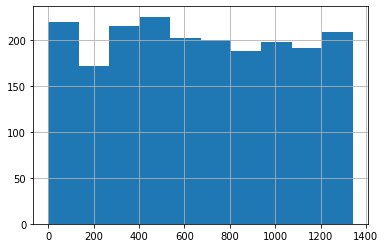

In [9]:

features['artist_names'].hist()

In [10]:
#features['song_title'].hist()

#### Normalizacion de los datos

In [11]:
features = features / features.max()
features.head()



,acousticness,loudness,tempo,energy,artist_names
0,0.010251,28.648208,0.684181,0.434870,0.334575
1,0.200000,33.879479,0.729869,0.359719,0.165425
2,0.034573,23.283388,0.342150,0.412826,0.334575
3,0.607035,49.628664,0.394235,0.338677,0.070790
4,0.180905,37.941368,0.793340,0.562124,0.467958


#### Separacion de datos en test y train



In [12]:
data_train, data_test, target_train, target_test = train_test_split(features, dataset_spotify['target'],shuffle = True, test_size=0.2, random_state = 2)



## Obtencion de los mejores hyperparametros y evaluacion del modelo

In [13]:
## optimizando hiperparametros con gridsearch

grid_params = {
    'n_neighbors':[5, 11, 15, 21, 25, 35, 41, 45, 49, 51, 53, 55, 75, 101],
    'metric':['euclidean', 'chebyshev'],
    'weights':['uniform', 'distance']
}

g_search = GridSearchCV(neighbors.KNeighborsClassifier(), grid_params, verbose = 1, cv = 5,n_jobs = -1 )
g_result = g_search.fit(data_train,  target_train)



Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    4.4s finished


### Evaluacion del modelo

In [14]:
KNN_best = g_result.best_estimator_
predicted = KNN_best.predict(data_test)
validation_acc = metrics.accuracy_score(target_test, predicted)
validation_recall = metrics.recall_score(target_test, predicted)
validation_f1 = metrics.f1_score(target_test, predicted)
precision = metrics.precision_score(target_test, predicted)

print("Grid scores on development set:\n")

print("Train accuracy: %f\n" % g_result.best_score_)

print("Grid scores on test set:\n")

print( "Validation accuracy: %f" % validation_acc)
print( "Validation recall: %f"   % validation_recall)
print( "Validation f1: %f"       % validation_f1)
print( "Validation precision: %f\n"       % precision)
print("Best hyperparameters: %s" % g_result.best_params_)


Grid scores on development set:

Train accuracy: 0.630492

Grid scores on test set:

Validation accuracy: 0.675743
Validation recall: 0.739796
Validation f1: 0.688836
Validation precision: 0.644444

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 101, 'weights': 'distance'}
